In [1]:
from train_model import *

In [2]:
train_occ_path=po_path_sampled_25
random_bg_path=None
val_occ_path=pa_path
env_model={'model_name':'ASPP', 'covariates':[bioclim_dir, soil_dir, landcover_path], 'patch_size': 10, 'embed_shape': 64, 'kernel_sizes': [1,3,3], 'dilations': [1,1,2]}
sat_model=None
n_max_low_occ=50
embed_shape=None
loss='an_full_loss'
lambda2=None
n_epochs=100
batch_size=128
learning_rate=1e-3
seed=42

In [3]:
model_setup = {}
if env_model is not None: model_setup['env'] = env_model
if sat_model is not None: model_setup['sat'] = sat_model
print(model_setup)

{'env': {'model_name': 'ASPP', 'covariates': ['data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/', 'data/full_data/EnvironmentalRasters/Soilgrids/', 'data/full_data/EnvironmentalRasters/LandCover/LandCover_MODIS_Terra-Aqua_500m.tif'], 'patch_size': 10, 'embed_shape': 64, 'kernel_sizes': [1, 3, 3], 'dilations': [1, 1, 2]}}


In [4]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"DEVICE: {dev}")

DEVICE: cuda


In [5]:
train_data, val_data, model, optimizer, multires = setup_model(
    model_setup, train_occ_path, random_bg_path, val_occ_path, n_max_low_occ,
    embed_shape, learning_rate, seed)
model = model.to(dev)


Making patch providers with size=10x10, flatten=False for covariates:
	 - data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/
	 - data/full_data/EnvironmentalRasters/Soilgrids/
	 - data/full_data/EnvironmentalRasters/LandCover/LandCover_MODIS_Terra-Aqua_500m.tif

Making dataset for training occurrences
nb items = 795688
nb species = 2088
nb of species with less than 50 occurrences = 658
input shape: [(41, 10, 10)]

Making dataset for validation occurrences
nb items = 7438
nb species = 2088
nb of species with less than 50 occurrences = 1736


In [6]:
batch_size=10
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=batch_size)#, num_workers=4)

In [7]:
loss_fn = eval(loss)
species_weights = torch.tensor(train_data.species_weights).to(dev)
val_loss_fn = torch.nn.BCELoss()

In [8]:
for po_inputs, bg_inputs, labels in tqdm(train_loader):
   labels = labels.to(torch.float32).to(dev)
   inputs = po_inputs[0].to(torch.float32).to(dev)
   break

  0%|          | 0/79569 [00:00<?, ?it/s]


In [9]:
y_pred = torch.sigmoid(model(inputs))

In [11]:
y_pred.shape

torch.Size([10, 2088])

In [20]:

x = inputs
x_in = [x[:, :, imin:imax, imin:imax] for imin, imax in zip(model.imins, model.imaxs)]

In [22]:
x_in[0].shape

torch.Size([10, 41, 1, 1])

In [26]:
m = model.aspp_branches[0].to(dev)
m(x_in[0])

tensor([[[[2.2347e+00]],

         [[0.0000e+00]],

         [[1.2005e+00]],

         [[0.0000e+00]],

         [[0.0000e+00]],

         [[0.0000e+00]],

         [[0.0000e+00]],

         [[0.0000e+00]],

         [[0.0000e+00]],

         [[2.6096e+00]],

         [[9.6059e-01]],

         [[0.0000e+00]],

         [[0.0000e+00]],

         [[1.4700e+00]],

         [[2.6196e-01]],

         [[0.0000e+00]],

         [[0.0000e+00]],

         [[0.0000e+00]],

         [[4.1660e-01]],

         [[0.0000e+00]],

         [[0.0000e+00]],

         [[4.2379e-02]],

         [[1.3564e+00]],

         [[3.5953e-01]],

         [[6.5525e-02]],

         [[0.0000e+00]],

         [[0.0000e+00]],

         [[0.0000e+00]],

         [[2.7790e+00]],

         [[0.0000e+00]],

         [[9.2368e-01]],

         [[6.2347e-01]],

         [[1.7214e+00]],

         [[0.0000e+00]],

         [[0.0000e+00]],

         [[0.0000e+00]],

         [[3.7026e-01]],

         [[0.0000e+00]],

         [[1

In [19]:

x = [aspp(xi) for aspp, xi in zip(model.aspp_branches, x_in)]

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [18]:
print([xi.get_device() for xi in x_in])

[0, 0, 0]


In [12]:
print(model.subpatch_sizes)
print(model.center_idx)
print(model.imins)
print(model.imaxs)

[1, 3, 5]
5
[5, 4, 3]
[6, 7, 8]


In [21]:
model.center_idx

2

True

In [27]:
[i >= 0 for i in imins]

AttributeError: 'list' object has no attribute 'all'

In [25]:
(np.array(imaxs) < 4).all()

False

In [13]:
    y_pred = torch.sigmoid(model(inputs))


True

In [24]:
from torch import nn

def aspp_branch(in_channels, out_channels, kernel_size, dilation):
    '''
    As implemented in:
    https://github.com/yassouali/pytorch-segmentation/blob/master/models/deeplabv3_plus.py
    '''
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size,dilation=dilation),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

In [26]:
kernel_sizes = [1, 3, 3, 3]
dilations = [1, 1, 2, 3]
subpatch_sizes = [(d-1)*(k-1) + k for k, d in zip(kernel_sizes, dilations)]
print(subpatch_sizes)
in_patch_size = 8
center_idx = in_patch_size // 2
print(center_idx)

[1, 3, 5, 7]
4


In [32]:
in_channels = 41
out_channels = 64
aspp_branches = [aspp_branch(in_channels, out_channels, k, d) for k, d in zip(kernel_sizes, dilations)]
len(aspp_branches)

4

In [35]:
x = po_inputs[0].to(torch.float32)
imins = [int(center_idx - (s-1)/2) for s in subpatch_sizes]
imaxs = [int(center_idx + (s-1)/2 + 1) for s in subpatch_sizes]
x_in = [x[:, :, imin:imax, imin:imax] for imin, imax in zip(imins, imaxs)]
x_out = [aspp(xi) for aspp, xi in zip(aspp_branches, x_in)]

In [36]:
print([o.shape for o in x_out])

[torch.Size([10, 64, 1, 1]), torch.Size([10, 64, 1, 1]), torch.Size([10, 64, 1, 1]), torch.Size([10, 64, 1, 1])]


In [52]:
x = torch.cat(x_out, dim=1).squeeze()
print(x.shape)

torch.Size([10, 256])


In [54]:
l = nn.Linear(256, 10)
l(x).shape

torch.Size([10, 10])

In [149]:
kernel_sizes = [1, 3, 3, 3]
dilations = [1, 1, 2, 3]
subpatch_sizes = [(d-1)*(k-1) + k for k, d in zip(kernel_sizes, dilations)]
print(subpatch_sizes)
in_patch_size = 9
center_idx = in_patch_size // 2
print(center_idx)

[1, 3, 5, 7]
4


In [150]:
imins = [int(center_idx - (s-1)/2) for s in subpatch_sizes]
imaxs = [int(center_idx + (s-1)/2 + 1) for s in subpatch_sizes]
x_in = [x[:, imin:imax, imin:imax] for imin, imax in zip(imins, imaxs)]
print([y.shape for y in x_in])

[torch.Size([41, 1, 1]), torch.Size([41, 3, 3]), torch.Size([41, 5, 5]), torch.Size([41, 7, 7])]


In [152]:
in_channels = 41
out_channels = 128
aspp_branches = [aspp_branch(in_channels, out_channels, k, d) for k, d in zip(kernel_sizes, dilations)]

In [157]:
xi = x_in[0].to(torch.double)
aspp = aspp_branches[0]
print(xi.shape)
print(aspp)

torch.Size([41, 1, 1])
Sequential(
  (0): Conv2d(41, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)


In [159]:
import pdb
pdb.set_trace()
aspp(xi)

--Return--
None
> /tmp/ipykernel_30382/2887211588.py(2)<module>()
      1 import pdb
----> 2 pdb.set_trace()
      3 aspp(xi)



In [141]:
x_out = [torch.rand((out_channels, 1, 1)) for i in range(5)]

In [146]:
torch.cat(x_out, dim=0).shape

torch.Size([640, 1, 1])

In [95]:
item = train_data.items.iloc[0]

In [96]:
print(f"{p.n_rows} - ({item.lat} - {p.y_min}) / {p.y_resolution})")
print(p.n_rows - (item.lat - p.y_min) / p.y_resolution)
x = int(p.n_rows - (item.lat - p.y_min) / p.y_resolution)
y = int((item.lon - p.x_min) / p.x_resolution)
print(x, y)

5467 - (34.59248 - 26.63319397795) / 0.0083333333)
4511.885673533543
4511 7833


In [97]:
print(f"{x} - ({p.patch_size} // 2), {x} + ({p.patch_size} // 2)")
print(x - (p.patch_size // 2), x + (p.patch_size // 2))

4511 - (9 // 2), 4511 + (9 // 2)
4507 4515


In [98]:
print(f"{y} - ({p.patch_size} // 2), {y} + ({p.patch_size} // 2)")
print(y - (p.patch_size // 2), y + (p.patch_size // 2))

7833 - (9 // 2), 7833 + (9 // 2)
7829 7837


In [99]:
patch_data = [p.data[i, x - (p.patch_size // 2): x + (p.patch_size // 2), y - (p.patch_size // 2): y + (p.patch_size // 2)] for i in range(p.nb_layers)]


In [100]:
patch_data[0].shape

(8, 8)

In [62]:
x = np.array([1,2,3,4,5,7,5,8,4,7,3,67,3,2,8,3,5,7,2,6,5,6])
x[3:8]

array([4, 5, 7, 5, 8])

In [49]:
4511-4447

64

In [9]:
for i, key in enumerate(model_setup.keys()):
    model_setup[key]['input_shape'] = train_data[0][0][i].shape
    if multires:
        assert embed_shape is not None
        model_setup[key]['output_shape'] = embed_shape
    else:
        model_setup[key]['output_shape'] = train_data.n_species
print([[m['input_shape'], m['output_shape']] for m in model_setup.values()])

[[(4, 10, 10), 2088]]


In [10]:
val_data = PatchesDatasetCooccurrences(
    occurrences=val_occ_path,
    providers=providers, 
    species=train_data.species, 
    n_low_occ=n_max_low_occ
)

nb items = 7438
nb species = 2088
nb of species with less than 50 occurrences = 1736


In [11]:
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=batch_size)#, num_workers=4)

In [13]:
model_list = [make_model(model_dict) for model_dict in model_setup.values()]
if multires:
    model = MultiScaleModel(
        model_list[0], model_list[1], train_data.n_species, embed_shape, embed_shape
    ).to(dev)
else:
    model = model_list[0].to(dev)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# loss functions
loss_fn = eval(loss)
species_weights = torch.tensor(train_data.species_weights).to(dev)
val_loss_fn = torch.nn.BCELoss()

In [21]:
arch ='resnet18'
block = BasicBlock
layers = [2, 2, 2, 2]
pretrained = False# 'ResNet18_Weights.IMAGENET1K_V1' 
progress = True

model = ResNet(block, layers, **kwargs)
    # if pretrained:
    #     state_dict = load_state_dict_from_url(model_urls[arch],
    #                                           progress=progress)
    #     model.load_state_dict(state_dict)

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [52]:
for po_inputs, bg_inputs, labels in tqdm(train_loader):
    labels = labels.to(torch.float32).to(dev) 
    print(labels.shape)

    if multires:
        inputsA = po_inputs[0].to(torch.float32).to(dev)
        inputsB = po_inputs[1].to(torch.float32).to(dev)
        y_pred = torch.sigmoid(model(inputsA, inputsB))

    else:
        if random_bg_path is None:
            inputs = po_inputs[0].to(torch.float32).to(dev)
            print(po_inputs[0].shape)
        else:
            inputs = torch.cat((po_inputs[0], bg_inputs[0]), 0).to(torch.float32).to(dev)
            print(po_inputs[0].shape, len(po_inputs))
            print(len(bg_inputs), bg_inputs[0].shape)
            print(inputs.shape)
        y_pred = torch.sigmoid(model(inputs))
            
    if random_bg_path is None:
       train_loss = loss_fn(y_pred, labels, species_weights)
          
    else:
        po_pred = y_pred[0:len(po_inputs[0])]
        bg_pred = y_pred[len(po_inputs[0]):]        
        train_loss = loss_fn(po_pred, labels, species_weights, lambda2, bg_pred)

    print(train_loss)
    break

  0%|          | 0/79569 [00:00<?, ?it/s]

torch.Size([10, 2088])


In [62]:
torch.sigmoid(model_list[0](inputsA)).min()

tensor(0.2431, device='cuda:0', grad_fn=<MinBackward1>)

In [64]:
torch.sigmoid(model_list[1](inputsB)).min()

tensor(0.0760, device='cuda:0', grad_fn=<MinBackward1>)

In [26]:
po_inputs[0].shape

torch.Size([10, 19])

In [4]:
    
model = get_model(model, input_shape[0], n_species, model_params, patch_size).to(dev)


DEVICE: cuda


In [5]:
flatten = [True if model == 'MLP' else False for model in models]
flatten

[True, False]

In [6]:
providers = []
for group, patch_size, f in zip(covariates, patch_sizes, flatten):

    group_providers = []
    for cov in group:
        print(f"\t - {cov}")
        if 'SatelliteImages' in cov:
            if f and patch_size != 1: 
                exit("jpeg patch provider for satellite images cannot flatten image patches")
            group_providers.append(JpegPatchProvider(cov, size=patch_size))
        elif '.tif' in cov:
            group_providers.append(RasterPatchProvider(cov, size=patch_size, flatten=f))
        else:
            group_providers.append(MultipleRasterPatchProvider(cov, size=patch_size, flatten=f))

    providers.append(group_providers)

	 - data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/
	 - data/full_data/SatelliteImages/


In [7]:
train_data = MultiScalePatchesDatasetCooccurrences(occurrences=train_occ_path, providersA=providers[0], providersB=providers[1])

nb items = 795688
nb species = 2088


In [14]:
tmp = train_data[0]

KeyboardInterrupt: 

In [13]:
index = 0
item = train_data.items.iloc[index][train_data.item_columns].to_dict()
item_species = train_data.items.iloc[index][train_data.label_name]
labels = 1 * np.isin(train_data.species, item_species)
labels

array([0, 0, 0, ..., 0, 0, 0])

In [10]:
next(iter(train_loader))

[tensor([[ 0.5785, -0.4444,  0.3936, -0.0497,  0.3133,  0.2105,  1.4341,  0.8035,
           0.0993, -0.1552,  0.5163, -0.1537, -0.8926,  0.5948, -0.2390,  0.0516,
          -0.0357,  0.1463,  0.0622],
         [-1.2090,  0.9438,  1.1360, -0.8559,  0.1914,  1.2281,  0.4841,  0.8553,
          -0.7493,  1.2138,  0.0333,  0.0904, -0.0533,  0.1836,  0.1192, -0.0894,
          -0.9101,  0.0355, -0.3035]], dtype=torch.float64),
 tensor([[[[ 0.7943,  0.9087,  0.7658,  ...,  0.2798,  0.2798, -0.0918],
           [ 0.3655,  0.7086,  0.6800,  ...,  0.1083,  0.3370,  0.2798],
           [ 0.2226,  0.8229,  0.9659,  ...,  0.3370,  0.1940,  0.0225],
           ...,
           [ 0.5942,  0.1940,  0.2226,  ..., -0.2062, -0.4635, -0.2348],
           [ 0.7658,  0.2226,  0.2798,  ...,  0.1940, -0.0633, -0.2062],
           [ 0.7943,  0.5085,  0.3941,  ...,  0.4799,  0.4227,  0.1369]],
 
          [[ 1.9485,  1.5270,  0.7892,  ...,  0.7892,  1.2459,  0.7541],
           [ 1.2108,  0.9298,  0.8946,  ...

In [12]:
tmp = train_data[0]

In [16]:
tmp[1].shape

(4, 64, 64)

In [11]:
input_shapes = [input.shape for input in train_data[0][0]]
n_species = train_data.n_species
print(f"input shape = {input_shapes}")

KeyboardInterrupt: 

In [11]:
n_max_low_occ = 50
low_occ_species = train_data.species_counts[train_data.species_counts <= n_max_low_occ].index
low_occ_species_idx = np.where(np.isin(train_data.species, low_occ_species))[0]
print(f"nb of species with less than {n_max_low_occ} occurrences = {len(low_occ_species_idx)}")

nb of species with less than 50 occurrences = 658


In [12]:
val_data = MultiScalePatchesDatasetCooccurrences(occurrences=val_occ_path, providers=providers, species=train_data.species)

nb items = 7438
nb species = 2088


In [24]:
batch_size = 2
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=batch_size)

In [17]:
modelA = MLP(input_shapes[0][0], 512, 5, 1000)
modelB = get_resnet(512)
model = MultiScaleModel(modelA, modelB, 512, 512, n_species)

In [18]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
loss_fn = eval(loss)
species_weights = torch.tensor(train_data.species_weights)
val_loss_fn = torch.nn.BCELoss()

In [26]:
batch = next(iter(train_loader))

In [31]:
batch[0][0].shape

torch.Size([2, 19])

In [36]:
(inputsA, inputsB), labels = batch
print(inputsA.shape, inputsB.shape, labels.shape)

torch.Size([2, 19]) torch.Size([2, 4, 64, 64]) torch.Size([2, 2088])


In [38]:
inputsA = inputsA.to(torch.float32)
inputsB = inputsB.to(torch.float32)
out = model(inputsA, inputsB)

In [40]:
out = torch.sigmoid(out)

In [42]:
out.shape

torch.Size([2, 2088])

In [27]:
1e-28 + 1e-05 * np.abs(p.nodata_value[0])

3.3999999500000004e+33

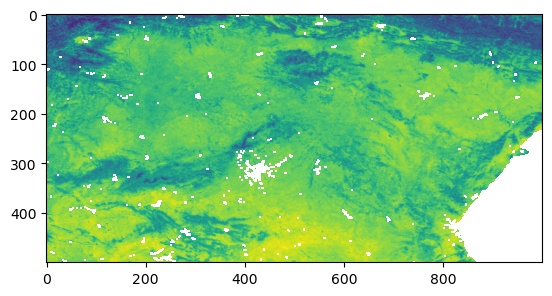

In [37]:
plt.imshow(np.where(np.isclose(p.data, p.nodata_value[0], atol=1e-8), np.nan, p.data)[0,3500:4000,3000:4000])

In [41]:
p_soil.rasters_providers[0].nodata_value

(-3.4e+38,)

In [32]:
for p in p_bioclim.rasters_providers[1:]:
    pseudoabsence_locations += np.where(p.data != 0, 1, 0)


In [37]:
np.sum(np.where(pseudoabsence_locations != 0, 1, 0))

44517781

In [21]:
5467*8143

44517781

In [14]:
for p in p_bioclim.rasters_providers:
    print(f"{p.name}: xmin={p.x_min} / ymin={p.y_min} / nrows={p.n_rows} / ncold={p.n_cols} / nlayers={p.nb_layers}")

bio9: xmin=-32.266806146449994 / ymin=26.63319397795 / nrows=5467 / ncold=8143 / nlayers=1
bio8: xmin=-32.266806146449994 / ymin=26.63319397795 / nrows=5467 / ncold=8143 / nlayers=1
bio7: xmin=-32.266806146449994 / ymin=26.63319397795 / nrows=5467 / ncold=8143 / nlayers=1
bio6: xmin=-32.266806146449994 / ymin=26.63319397795 / nrows=5467 / ncold=8143 / nlayers=1
bio5: xmin=-32.266806146449994 / ymin=26.63319397795 / nrows=5467 / ncold=8143 / nlayers=1
bio4: xmin=-32.266806146449994 / ymin=26.63319397795 / nrows=5467 / ncold=8143 / nlayers=1
bio3: xmin=-32.266806146449994 / ymin=26.63319397795 / nrows=5467 / ncold=8143 / nlayers=1
bio2: xmin=-32.266806146449994 / ymin=26.63319397795 / nrows=5467 / ncold=8143 / nlayers=1
bio19: xmin=-32.266806146449994 / ymin=26.63319397795 / nrows=5467 / ncold=8143 / nlayers=1
bio18: xmin=-32.266806146449994 / ymin=26.63319397795 / nrows=5467 / ncold=8143 / nlayers=1
bio17: xmin=-32.266806146449994 / ymin=26.63319397795 / nrows=5467 / ncold=8143 / nlayer

In [15]:
for p in p_soil.rasters_providers:
    print(f"{p.name}: xmin={p.x_min} / ymin={p.y_min} / nrows={p.n_rows} / ncold={p.n_cols} / nlayers={p.nb_layers}")

crop_proj_soc_5-15cm_mean_1000: xmin=-32.266806146449994 / ymin=26.63319397795 / nrows=5467 / ncold=8143 / nlayers=1
crop_proj_silt_5-15cm_mean_1000: xmin=-32.266806146449994 / ymin=26.63319397795 / nrows=5467 / ncold=8143 / nlayers=1
crop_proj_sand_5-15cm_mean_1000: xmin=-32.266806146449994 / ymin=26.63319397795 / nrows=5467 / ncold=8143 / nlayers=1
crop_proj_phh2o_5-15cm_mean_1000: xmin=-32.266806146449994 / ymin=26.63319397795 / nrows=5467 / ncold=8143 / nlayers=1
crop_proj_nitrogen_5-15cm_mean_1000: xmin=-32.266806146449994 / ymin=26.63319397795 / nrows=5467 / ncold=8143 / nlayers=1
crop_proj_clay_5-15cm_mean_1000: xmin=-32.26680614645 / ymin=26.63319397795 / nrows=5467 / ncold=8143 / nlayers=1
crop_proj_cfvo_5-15cm_mean_1000: xmin=-32.26680614645 / ymin=26.63319397795 / nrows=5467 / ncold=8143 / nlayers=1
crop_proj_cec_5-15cm_mean_1000: xmin=-32.266806146449994 / ymin=26.63319397795 / nrows=5467 / ncold=8143 / nlayers=1
crop_proj_bdod_5-15cm_mean_1000: xmin=-32.26680614645 / ymin=

In [37]:
# patch_size = 1
# flatten = True 
# p_bioclim = MultipleRasterPatchProvider(bioclim_dir, size=patch_size, flatten=flatten) 
# p_soil = MultipleRasterPatchProvider(soil_dir, size=patch_size, flatten=flatten) 
# p_landcover = RasterPatchProvider(landcover_dir, size=patch_size, flatten=flatten)
p_sat = JpegPatchProvider(sat_dir, size = 128)

In [38]:
train_data = PatchesDatasetCooccurrences(occurrences=po_path, providers=(p_sat))
print(f"\nTRAINING DATA: n_items={len(train_data)}, n_species={len(train_data.species)}")
print(train_data[0][0].shape, train_data[0][1].shape)

n_features = train_data[0][0].shape[0]
n_species = len(train_data.species)
print(f"nb of features = {n_features}")

val_data = PatchesDatasetCooccurrences(occurrences=pa_path, providers=(p_sat), species=train_data.species)
print(f"\nVALIDATION DATA: n_items={len(val_data)}, n_species={len(val_data.species)}")
print(val_data[0][0].shape, val_data[0][1].shape)


TRAINING DATA: n_items=2856818, n_species=2174
(4, 128, 128) (2174,)
nb of features = 4

VALIDATION DATA: n_items=7438, n_species=2174
(4, 128, 128) (2174,)


In [40]:
low_occ_species = train_data.species_counts[train_data.species_counts < 50].index
low_occ_species

Int64Index([  124,   125,   135,   150,   255,   263,   270,   291,   293,
              314,
            ...
             9843,  9846,  9884,  9935,  9976, 10002, 10005, 10013, 10031,
            10038],
           dtype='int64', length=467)

In [41]:
low_occ_species_idx = np.where(np.isin(train_data.species, low_occ_species))

In [47]:
low_occ_species_idx[0].shape

(467,)

In [48]:
val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=1024)
labels_list = []
for inputs, labels in tqdm(val_loader):
    labels_list.append(labels.numpy())
labels = np.concatenate(labels_list)
print(labels.shape)

100%|██████████| 8/8 [00:09<00:00,  1.18s/it]

(7438, 2174)


In [50]:
labels[:, low_occ_species_idx].shape

(7438, 1, 467)

In [61]:
pred = torch.rand(labels.shape).numpy()
pred.shape

(7438, 970)

In [62]:
roc_auc_score(labels, pred)

0.5000934604360244

In [65]:
roc_auc_score(labels[:, low_occ_species_idx], pred[:, low_occ_species_idx])

0.502039523418048

In [64]:
.shape

(7438, 100)

In [68]:
model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
weights = model.conv1.weight.data.clone()
model.conv1 = torch.nn.Conv2d(6, 64, kernel_size=(7,7), stride=(2,2),
                              padding=(3,3), bias=False)
# first three bands are RGB
model.conv1.weight.data[:, :3, :, :] = weights

In [70]:
model.conv1.weight.data.size()

torch.Size([64, 6, 7, 7])

In [72]:
model.conv1.weight.data[:, 3:, :, :].size()

torch.Size([64, 3, 7, 7])

In [80]:
weights[:,0,:,:].repeat((3,1,1,1)).reshape((64,3,7,7))[0,:,:,0]

tensor([[-1.0419e-02,  1.1083e-02, -6.9434e-03,  3.0505e-02, -2.7535e-02,
          3.0613e-02, -1.3736e-02],
        [-4.4154e-03,  5.1310e-02, -7.3337e-03, -5.8778e-02, -2.6754e-02,
          2.3524e-02,  2.8689e-02],
        [-7.0826e-08, -6.1125e-09,  7.1953e-08,  7.7593e-08,  9.5889e-08,
          1.2904e-07,  1.2558e-07]])

In [83]:
weights[0,0,:,0]

tensor([-0.0104,  0.0111, -0.0069,  0.0305, -0.0275,  0.0306, -0.0137])

In [62]:
model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
weights = model.conv1.weight.data.clone()
model.conv1 = torch.nn.Conv2d(len(p_sat.bands_names), 64, kernel_size=(7,7), stride=(2,2),
                              padding=(3,3), bias=False)
# first three bands are RGB
model.conv1.weight.data[:, :3, :, :] = weights
# initialize weights for 4th band (NIR) to pretrained weights for R
model.conv1.weight.data[:,-1,:,:] = weights[:,0,:,:]
model.fc = torch.nn.Linear(512, n_species)

In [63]:
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=100)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
loss_fn = torch.nn.BCELoss()

In [67]:
for inputs, labels in train_loader:
    print('-----------------------')
    inputs = inputs.to(torch.float32)
    labels = labels.to(torch.float32)

    print(inputs.size())
    print(labels.size())
    pred = model(inputs)
    print(pred.size())
    pred_sigmoid = torch.sigmoid(pred)
    loss = loss_fn(pred_sigmoid, labels)
    print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

-----------------------
torch.Size([100, 4, 128, 128])
torch.Size([100, 970])
torch.Size([100, 970])
tensor(0.7661, grad_fn=<BinaryCrossEntropyBackward0>)
-----------------------
torch.Size([100, 4, 128, 128])
torch.Size([100, 970])
torch.Size([100, 970])
tensor(0.7662, grad_fn=<BinaryCrossEntropyBackward0>)


KeyboardInterrupt: 

In [25]:
img = (img - p_sat.stats[folder]['mean']) / p_sat.stats[folder]['std']
img[0:4,0:4]

array([[[1.35131398, 1.10365753, 1.16046181],
        [1.35131398, 1.14308757, 1.121358  ],
        [1.38644307, 1.10365753, 1.121358  ],
        [1.49183034, 1.14308757, 1.19956562]],

       [[1.56208853, 1.37966779, 1.35598084],
        [1.59721762, 1.41909782, 1.39508465],
        [1.70260489, 1.45852786, 1.47329226],
        [1.73773398, 1.41909782, 1.47329226]],

       [[1.70260489, 1.53738793, 1.51239607],
        [1.59721762, 1.41909782, 1.39508465],
        [1.63234671, 1.37966779, 1.39508465],
        [1.6674758 , 1.41909782, 1.35598084]],

       [[1.91337944, 1.77396815, 1.74701891],
        [1.56208853, 1.37966779, 1.27777323],
        [1.42157216, 1.14308757, 1.08225419],
        [1.59721762, 1.34023775, 1.27777323]]])

In [31]:
(122-77.3)/25.6
# [[140, 134, 122],
# [130, 124, 110],
# [126, 118, 105],
# [131, 123, 110]]]

# {'rgb': {'mean': array([85.53290863, 89.00972544, 77.32355934]),
#   'std': array([28.46643494, 25.3613768 , 25.57295764])},

1.74609375

In [ ]:

        tensor_list = []
        for folder in set([self.channel_folder[x] for x in self.channels]):
            path = os.path.join(self.root_path, folder, sub_folder_1, sub_folder_2, patch_id+self.ext)
            img = np.asarray(Image.open(path))
            if self.normalize:
                img = (img - self.stats[folder]['mean']) / self.stats[folder]['std']
            if folder == 'rgb':
                img = img.transpose((2,0,1))
            else:
                img = np.expand_dims(img, axis=0)
            tensor_list.append(img)

        tensor = np.concatenate(tensor_list)   

In [7]:
n_layers=5
width=1000
learning_rate = 1e-3

checkpoint = torch.load(f"models/0129_MLP_env_1x1_an_slds/last.pth") 
model = MLP(n_features, n_species, n_layers, width).to(dev)
model.load_state_dict(checkpoint['state_dict'])

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [8]:
batch_size = 100
val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=batch_size)

In [9]:
model.eval()
for inputs, labels in tqdm(val_loader):

    inputs = inputs.to(torch.float32).to(dev)
    labels = labels.to(torch.float32).to(dev) 

    y_pred = model(inputs)
    y_pred_sigmoid = torch.sigmoid(y_pred)
    break

  0%|          | 0/75 [00:00<?, ?it/s]


In [10]:
from util import full_weighted_loss, log_loss, an_slds_loss

In [28]:
site_loss = ((log_loss(y_pred_sigmoid) * labels) + (log_loss(1 - y_pred_sigmoid) * (1 - labels))).sum(axis=1)
site_loss

tensor([106.8681,  45.5787, 144.8981,  70.2276,  69.8719, 112.8003,  62.7500,
         82.3768,  36.6073, 184.6388,  77.1216,  72.7857, 113.3533, 117.8457,
        202.0119,  71.3230,  79.6669,  37.1057, 141.3414,  57.0748, 132.5101,
         85.3297,  62.0836,  49.5300,  54.6256,  34.3797,  77.3789, 173.8106,
         64.9701, 127.9944,  57.2855,  97.8895,  51.8376,  88.0655, 109.3177,
        132.1242, 106.3008,  69.8161,  99.7802, 100.4560, 275.9788, 346.0638,
        126.0209, 281.7271,  97.2427, 221.4101, 211.8990, 102.8910, 163.4634,
         41.5764, 101.1121, 165.3643, 336.8092,  71.8653,  99.8071,  66.5811,
         56.4781, 168.0095,  39.2877,  52.1725, 219.6209, 200.0959, 171.7413,
        265.4856, 175.7674, 158.0072, 112.1769, 169.8835, 154.3561, 139.3261,
        162.3870,  95.9657, 185.2584, 107.3661, 168.4667, 113.6763, 178.3697,
         72.2473, 215.3839, 102.5622, 211.9854, 240.1242,  98.8133,  38.8538,
        155.6076, 224.3242, 230.9366, 150.0206,  70.6028, 102.18

In [36]:
site_weight = 1 / (labels.sum(axis=1) + 1e-5)
site_weight

tensor([5.8823e-02, 1.1111e-01, 4.7619e-02, 8.3333e-02, 7.1429e-02, 4.7619e-02,
        1.0000e-01, 7.6923e-02, 2.0000e-01, 3.7037e-02, 9.0909e-02, 8.3333e-02,
        4.7619e-02, 5.2632e-02, 3.4483e-02, 1.0000e-01, 7.6923e-02, 1.6667e-01,
        4.3478e-02, 9.0909e-02, 5.2632e-02, 7.1429e-02, 1.1111e-01, 1.2500e-01,
        9.0909e-02, 2.0000e-01, 7.6923e-02, 3.8462e-02, 1.0000e-01, 4.5455e-02,
        1.1111e-01, 7.1429e-02, 1.4286e-01, 7.1429e-02, 6.6667e-02, 5.2632e-02,
        5.5556e-02, 8.3333e-02, 6.6667e-02, 5.8823e-02, 2.3810e-02, 1.8868e-02,
        5.2632e-02, 2.4390e-02, 6.6667e-02, 2.8571e-02, 3.1250e-02, 6.2500e-02,
        4.0000e-02, 1.6667e-01, 6.2500e-02, 4.0000e-02, 2.0000e-02, 9.0909e-02,
        7.1429e-02, 1.0000e-01, 1.1111e-01, 3.8462e-02, 1.6667e-01, 1.2500e-01,
        3.0303e-02, 3.3333e-02, 4.0000e-02, 2.4390e-02, 3.7037e-02, 4.3478e-02,
        5.8823e-02, 3.8462e-02, 4.3478e-02, 4.7619e-02, 4.0000e-02, 6.6667e-02,
        3.5714e-02, 6.6667e-02, 4.0000e-

In [37]:
(site_loss * site_weight)

tensor([6.2864e+00, 5.0643e+00, 6.8999e+00, 5.8523e+00, 4.9908e+00, 5.3714e+00,
        6.2750e+00, 6.3367e+00, 7.3214e+00, 6.8385e+00, 7.0110e+00, 6.0655e+00,
        5.3978e+00, 6.2024e+00, 6.9659e+00, 7.1323e+00, 6.1282e+00, 6.1843e+00,
        6.1453e+00, 5.1886e+00, 6.9742e+00, 6.0950e+00, 6.8982e+00, 6.1912e+00,
        4.9660e+00, 6.8759e+00, 5.9522e+00, 6.6850e+00, 6.4970e+00, 5.8179e+00,
        6.3651e+00, 6.9921e+00, 7.4054e+00, 6.2904e+00, 7.2878e+00, 6.9539e+00,
        5.9056e+00, 5.8180e+00, 6.6520e+00, 5.9092e+00, 6.5709e+00, 6.5295e+00,
        6.6327e+00, 6.8714e+00, 6.4828e+00, 6.3260e+00, 6.6218e+00, 6.4307e+00,
        6.5385e+00, 6.9294e+00, 6.3195e+00, 6.6146e+00, 6.7362e+00, 6.5332e+00,
        7.1291e+00, 6.6581e+00, 6.2753e+00, 6.4619e+00, 6.5479e+00, 6.5216e+00,
        6.6552e+00, 6.6699e+00, 6.8696e+00, 6.4753e+00, 6.5099e+00, 6.8699e+00,
        6.5986e+00, 6.5340e+00, 6.7111e+00, 6.6346e+00, 6.4955e+00, 6.3977e+00,
        6.6164e+00, 7.1577e+00, 6.7387e+

In [59]:
labels.sum(axis=1)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 3., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 1., 1., 1., 3., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

In [63]:
((log_loss(y_pred_sigmoid) * labels) + (log_loss(1 - y_pred_sigmoid) * (1 - labels))).size()

torch.Size([100, 970])

In [75]:
torch.transpose((1/labels.sum(axis=1)).repeat((970,1)), 0, 1).size()

torch.Size([100, 970])

In [48]:
y_pred_sigmoid = torch.sigmoid(y_pred)

In [77]:
((log_loss(y_pred_sigmoid) * labels) + (log_loss(1 - y_pred_sigmoid) * (1 - labels)))

tensor([[0.5036, 0.4159, 1.7799,  ..., 0.9572, 1.0645, 0.9608],
        [0.1574, 0.1706, 2.9006,  ..., 0.1897, 0.3298, 0.1231],
        [0.2147, 0.2465, 2.3799,  ..., 0.2062, 0.3572, 0.2083],
        ...,
        [0.3140, 0.1083, 1.4215,  ..., 0.4738, 1.5109, 1.0405],
        [0.2706, 0.4160, 0.5155,  ..., 4.4013, 0.3735, 0.6763],
        [0.3368, 0.2044, 1.4221,  ..., 1.1035, 1.1413, 0.5425]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [79]:
per_site_loss = ((log_loss(y_pred_sigmoid) * labels) + (log_loss(1 - y_pred_sigmoid) * (1 - labels))) * torch.transpose((1/labels.sum(axis=1)).repeat((970,1)), 0, 1)

In [89]:
((log_loss(y_pred_sigmoid) * labels) + (log_loss(1 - y_pred_sigmoid) * (1 - labels))).sum(axis=1).size()

torch.Size([100])

In [91]:
(1/labels.sum(axis=1)).size()

torch.Size([100])

In [92]:
site_loss = ((log_loss(y_pred_sigmoid) * labels) + (log_loss(1 - y_pred_sigmoid) * (1 - labels))).sum(axis=1)
site_weight = (1/labels.sum(axis=1))
print(site_loss.size(), site_weight.size())

torch.Size([100]) torch.Size([100])


In [94]:
(site_loss * site_weight).mean()

tensor(1037.8966, device='cuda:0', grad_fn=<MeanBackward0>)

In [84]:
per_site_loss.sum() 

tensor(103789.6641, device='cuda:0', grad_fn=<SumBackward0>)

In [14]:
species_weights = torch.tensor(train_data.species_weights)
species_weights.size()

torch.Size([970])

In [35]:
(log_loss(pred) * labels).shape# * species_weights.repeat((batch_size, 1))).mean()


torch.Size([100, 96])

In [16]:
pred * labels

RuntimeError: The size of tensor a (96) must match the size of tensor b (970) at non-singleton dimension 1

In [56]:
np.ones(labels.shape[1]).shape

(96,)

In [58]:
labels.shape

torch.Size([100, 96])

In [64]:
species_weights = torch.tensor(train_data.species_weights.values)

In [65]:
species_weights.repeat((100,1)).size()

torch.Size([100, 96])

In [67]:
species_weights

tensor([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100.,  50., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100.,  50., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         50., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,  50.],
       dtype=torch.float64)

In [70]:
(species_weights/(species_weights-1)).repeat((batch_size,1)).size()

torch.Size([100, 96])

In [12]:
index = 0 
item_columns=['lat','lon','patchID','dayOfYear']
train_data.items.iloc[index][item_columns].to_dict()

{'lat': 34.57748, 'lon': 32.98918, 'patchID': 6999895, 'dayOfYear': 72}

In [14]:
train_data.items.iloc[index]['speciesId']

[9807]

In [9]:
for inputs, labels in tqdm(train_loader):
    print(inputs.shape, labels.shape)

  0%|          | 0/19449 [00:21<?, ?it/s]


KeyboardInterrupt: 

In [32]:
img.shape

(3, 128, 128)

In [33]:
img[:,0:2,0:2]

array([[[89, 90],
        [93, 92]],

       [[85, 86],
        [89, 88]],

       [[73, 74],
        [77, 76]]], dtype=uint8)

In [34]:
((img - stats[folder]['mean']) / stats[folder]['std'])[:,0:2,0:2]

ValueError: operands could not be broadcast together with shapes (3,128,128) (3,) 

In [98]:
img_shape = np.array(Image.open(files[0], mode='r')).shape 
dims = len(img_shape)
dims

3

In [99]:
img_shape

(128, 128, 3)

In [100]:
sums = np.array([0.0] * img_shape[2]) if dims == 3 else np.array([0.0])
n_terms = 0

for f in files:
    img = np.array(Image.open(f, mode='r'))
    nans = np.sum(np.isnan(img))
    if nans != 0: 
        print(f)
        break
    img_sum = np.sum(img, axis=(0,1))
    sums += img_sum
    n_terms += img.shape[0] * img.shape[1]

In [76]:
sums

array([2.35789956e+08])

In [101]:
means = sums / n_terms
means

array([83.14263306, 86.63155151, 75.32485657])

In [104]:
pd.DataFrame({'mean': means}).to_csv('data/sample_data/SatelliteImages/rgb_means.csv', index=False)

In [123]:
means = pd.read_csv('data/sample_data/SatelliteImages/rgb_means.csv')
means = np.array(means['mean'])
means

array([83.14263306, 86.63155151, 75.32485657])

In [119]:
sums = np.array([0.0] * img_shape[2]) if dims == 3 else np.array([0.0])
n_terms = 0

for f in files:
    img = np.array(Image.open(f, mode='r'))
    sum_dev_mean = np.sum(np.power(img - means, 2), axis=(0,1))
    sums += sum_dev_mean
    n_terms += img.shape[0] * img.shape[1]    

In [121]:
std_devs = np.power(sums / n_terms, 0.5)
std_devs

array([28.05194011, 25.23968003, 24.4220831 ])

In [122]:
pd.DataFrame({'std_dev': std_devs}).to_csv('data/sample_data/SatelliteImages/rgb_std_devs.csv', index=False)

In [77]:
datadir = 'data/full_data/'
bioclim_dir = datadir+'EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/'
soil_dir = datadir+'EnvironmentalRasters/Soilgrids/'
po_path = datadir+'Presence_only_occurrences/Presences_only_train_sampled_10_percent_min_100_occurrences.csv' #Presences_only_train_sampled_25_percent_min_10_occurrences.csv'
pa_path = datadir+'Presence_Absence_surveys/Presences_Absences_train.csv'

In [78]:
occurrences=po_path
label_name='speciesId'
item_columns=['lat','lon','patchID','dayOfYear']
df = pd.read_csv(occurrences, sep=";", header='infer', low_memory=False)
items = pd.DataFrame(df.groupby(item_columns)[label_name].agg(list)).reset_index()

In [81]:
root_path = sat_dir
ext = '.jpeg'
sub_dirs = next(os.walk(root_path))[1]
select = [x for x in ['rgb','nir'] if x in sub_dirs]
channels = ['red','green','blue'] + [x for x in select if x != 'rgb']
channel_folder = {'red': 'rgb', 'green': 'rgb', 'blue': 'rgb','nir':'nir'}

In [83]:
item = items.iloc[0][item_columns].to_dict()
patch_id = str(int(item['patchID']))
sub_folder_1 = patch_id[-2:]
sub_folder_2 = patch_id[-4:-2]

In [119]:
for folder in set([channel_folder[x] for x in channels]):
    path = os.path.join(root_path, folder, sub_folder_1, sub_folder_2, patch_id+ext)
    print(folder, path)
    
    img = np.asarray(Image.open(path))
    if folder == 'rgb':
        img = img.transpose((2,0,1))
    else:
        img = np.expand_dims(img, axis=0)
    
    stats_path = os.path.join(root_path, folder+'_stats.csv')
    print(stats_path)
    stats = pd.read_csv(stats_path, sep=';', index_col=0)
    #mean, std = df.loc[0, 'mean'], df.loc[0, 'std']
                #     img = (img-mean)/std

nir data/sample_data/SatelliteImages/nir/71/87/6998771.jpeg
data/sample_data/SatelliteImages/nir_stats.csv
rgb data/sample_data/SatelliteImages/rgb/71/87/6998771.jpeg
data/sample_data/SatelliteImages/rgb_stats.csv


In [120]:
stats

,mean,std
0,83.142633,28.051940
1,86.631552,25.239680
2,75.324857,24.422083


In [121]:
img.shape

(3, 128, 128)

In [122]:
img[:,0:3,0:3]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[4, 4, 4],
        [4, 4, 4],
        [4, 2, 2]]], dtype=uint8)

In [123]:
for i in range(img.shape[0]):
    img[i,:,:] = img[i,:,:] - stats.loc[i,'mean']

ValueError: assignment destination is read-only

In [76]:
stats = pd.DataFrame({
    'mean': np.nanmean(imgs,axis=(0,2,3)),
    'std': np.nanstd(imgs,axis=(0,2,3))
})
stats


,mean,std
0,83.142633,28.051940
1,86.631552,25.239680
2,75.324857,24.422083


In [41]:
re_imgs = imgs.reshape(3,100,128,128)
re_imgs[:, 0, 0:3, 0:3]

array([[[127, 141, 154],
        [138, 133, 138],
        [121, 108, 117]],

       [[110, 129, 134],
        [111, 118, 120],
        [111, 112, 107]],

       [[ 84,  76,  74],
        [ 69,  68,  69],
        [ 59,  64,  68]]], dtype=uint8)

In [5]:
train_data = MultiScalePatchesDatasetCooccurrences(
    occurrences=po_path, 
    providers=((p_bioclim, p_soil))
)

In [16]:
providers = (p_bioclim, p_soil, p_sat)
patch_sizes = [p.patch_size for p in providers]
patch_sizes

[1, 1, 64]

In [1]:
train_data[0][0]

NameError: name 'train_data' is not defined

In [21]:
unique_patch_sizes = list(set(patch_sizes))
providers_grouped = []
for patch_size in unique_patch_sizes:


[[False, False, True], [True, True, False]]

In [6]:
len(train_data[0][0])

2

In [7]:
train_data[0][0][0].shape

(19,)

In [8]:
train_data[0][0][1].shape

(9,)

In [9]:
train_data.n_groups

2

In [37]:
batch_size = 10
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

In [38]:
for inputs, labels in tqdm(train_loader):
    inputs = inputs#.to(torch.float32)
    labels = labels#.to(torch.float32)
    break

    env = inputs[0].to(torch.float32)
    sat = inputs[1].to(torch.float32)

    print(len(inputs))
    print(labels.shape)

    env_vars = inputs[0]
    sat_vars = inputs[1]
    print(env_vars.shape, sat_vars.shape)

    break
#1m32s for ((p_bioclim, p_soil), (p_sat))

  0%|          | 0/31118 [01:21<?, ?it/s]


In [33]:
env = inputs[0].to(torch.float32)
sat = inputs[1].to(torch.float32)
print(env.shape, sat.shape)

torch.Size([10, 28]) torch.Size([10, 4, 64, 64])


In [32]:
labels.shape

torch.Size([10, 970])

In [19]:
sat_img = train_data[0][0][1]

In [12]:
labels = train_data[0][1]

In [15]:
occurrences=po_path
label_name='speciesId'
item_columns=['lat','lon','patchID','dayOfYear']
df = pd.read_csv(occurrences, sep=";", header='infer', low_memory=False)
species = np.unique(df[label_name].values)
items = pd.DataFrame(df.groupby(item_columns)[label_name].agg(list)).reset_index()
providers = ((p_bioclim, p_soil), (p_sat))

2

In [28]:
patch_sizes = []
one_provider_in_group = []
for provider in providers:
    try:
        patch_sizes.append(provider.patch_size)
        one_provider_in_group.append(True)
    except:
        group_patch_sizes = [p.patch_size for p in provider]
        print('group', group_patch_sizes)
        assert len(set(group_patch_sizes)) == 1
        patch_sizes.append(group_patch_sizes[0])
        one_provider_in_group.append(False)
print(patch_sizes)
print(one_provider_in_group)

        

group [1, 1]
[1, 64]
[False, True]


In [30]:
provider_list = [MetaPatchProvider(p, one_provider=one_p) for p, one_p in zip(providers, one_provider_in_group)]
    

In [10]:
# get item
item = items.iloc[0][item_columns].to_dict()
item

{'lat': 34.57748, 'lon': 32.98918, 'patchID': 6999895, 'dayOfYear': 72}

In [11]:
patches = []
for p in provider_list:
    patch = p[item]
    print(patch.shape)
    patches.append(patch)

(28,)
(4, 64, 64)


In [13]:
env = patches[0]
rgb = patches[1]

In [23]:
for pro in p:
    print(str(pro))

TypeError: 'int' object is not subscriptable

In [11]:
MetaPatchProvider(p_sat, one_provider=True)

TypeError: 'int' object is not subscriptable

In [24]:
MetaPatchProvider(providers[1], one_provider=True)

TypeError: 'int' object is not subscriptable

In [22]:
MetaPatchProvider(providers[0])

Providers:
Rasters in folder:
band_names: ['bio9']
n_layers: 1
x_min: -32.266806146449994
y_min: 26.63319397795
x_resolution: 0.0083333333
y_resolution: 0.0083333333
n_rows: 5467
n_cols: 8143
--------------------------------------------------
band_names: ['bio8']
n_layers: 1
x_min: -32.266806146449994
y_min: 26.63319397795
x_resolution: 0.0083333333
y_resolution: 0.0083333333
n_rows: 5467
n_cols: 8143
--------------------------------------------------
band_names: ['bio7']
n_layers: 1
x_min: -32.266806146449994
y_min: 26.63319397795
x_resolution: 0.0083333333
y_resolution: 0.0083333333
n_rows: 5467
n_cols: 8143
--------------------------------------------------
band_names: ['bio6']
n_layers: 1
x_min: -32.266806146449994
y_min: 26.63319397795
x_resolution: 0.0083333333
y_resolution: 0.0083333333
n_rows: 5467
n_cols: 8143
--------------------------------------------------
band_names: ['bio5']
n_layers: 1
x_min: -32.266806146449994
y_min: 26.63319397795
x_resolution: 0.0083333333
y_resolut

In [7]:
provider_patch_sizes = [p.patch_size for p in providers]
provider_patch_sizes

[1, 1, 64]

In [8]:
unique_patch_sizes = list(set(provider_patch_sizes))
num_patch_sizes = len(unique_patch_sizes)

In [10]:
for p in unique_patch_sizes:
    idx = list(np.where(np.array(provider_patch_sizes) == p)[0])
    print('--------------------------------------------')
    print(p, idx)
    one_provider = True if len(idx)==1 else False
    meta_p = MetaPatchProvider((providers[i] for i in idx), one_provider)
    print(meta_p)


--------------------------------------------
64 [2]


TypeError: object of type 'generator' has no len()

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 2 has 3 dimension(s)

In [8]:
root_path = sat_dir
sub_dirs = next(os.walk(root_path))[1]
sub_dirs

['nir', 'rgb']

In [50]:
# Dataset
train_data = PatchesDataset(occurrences=po_path, providers=(p_bioclim, p_soil, p_sat))
occurrences=po_path
#providers=(p_bioclim, p_soil)
label_name='speciesId'
item_columns=['lat','lon','patchID','dayOfYear']
df = pd.read_csv(occurrences, sep=";", header='infer', low_memory=False)
species = np.unique(df[label_name].values)
items = df[item_columns + [label_name]]

In [51]:
index = 0
item = items.iloc[index][item_columns].to_dict()
item

{'lat': 59.2511, 'lon': 10.95154, 'patchID': 5982155.0, 'dayOfYear': 168.0}

In [57]:
patch_id = str(int(item['patchID']))
sub_folder_1 = patch_id[-2:]
sub_folder_2 = patch_id[-4:-2]
ext = '.jpeg'
patch_id

'5982155'

In [58]:
root_path = 'data/sample_data/SatelliteImages/'
channel_folder = {'red': 'rgb', 'green': 'rgb', 'blue': 'rgb','nir':'nir'}

In [61]:
folder = 'rgb'
path = os.path.join(root_path, folder, sub_folder_1, sub_folder_2, patch_id+ext)
img = np.asarray(Image.open(path)) 
img = img.transpose((2,0,1))
img.shape

(3, 128, 128)

In [71]:
img[0].shape[1]

128

In [35]:
list_tensor = {'order': [], 'tensors':[]}
for channel, channel_filename in channels_dict.items():
    print(channel)
    if channel not in list_tensor['order']:
        path = os.path.join(root_path, channel_filename, sub_folder_1, sub_folder_2, patch_id+ext)
        print(path)
        img = np.asarray(Image.open(path))
        print(img.shape)
        if channel in ['red','green','blue']:
            img = img.transpose((2,0,1))
            print(img.shape)

red
data/full_data/SatelliteImages/rgb/55/21/5982155.jpeg
(128, 128, 3)
(3, 128, 128)
green
data/full_data/SatelliteImages/rgb/55/21/5982155.jpeg
(128, 128, 3)
(3, 128, 128)
blue
data/full_data/SatelliteImages/rgb/55/21/5982155.jpeg
(128, 128, 3)
(3, 128, 128)
nir
data/full_data/SatelliteImages/nir/55/21/5982155.jpeg
(128, 128)


In [17]:
patch_id = str(int(item['patchID']))
rgb_path = f"{self.rgbnir_dir}rgb/{patch_id[-2:]}/{patch_id[-4:-2]}/{patch_id}.jpeg"
rgb_img = (np.asarray(Image.open(rgb_path)) / 255.0).transpose((2,0,1))

nir_path = f"{self.rgbnir_dir}nir/{patch_id[-2:]}/{patch_id[-4:-2]}/{patch_id}.jpeg"
nir_img = np.expand_dims(np.asarray(Image.open(nir_path)) / 255.0, axis=0)

rgbnir = np.concatenate([rgb_img, nir_img])
if self.rgbnir_patch_size != 128:
    rgbnir = rgbnir[:, round((rgbnir[0].shape[0] - self.rgbnir_patch_size) /2):round((rgbnir[0].shape[0] + self.rgbnir_patch_size) /2),
                                    round((rgbnir[0].shape[1] - self.rgbnir_patch_size) /2):round((rgbnir[0].shape[1] + self.rgbnir_patch_size) /2)]
     

76 02


In [9]:
items[1]

KeyError: 1

In [ ]:
#class JpegPatchProvider(PatchProvider)
# init


In [ ]:
print(len(train_data.species), train_data.species[0:10])

In [ ]:
label_name='speciesId'
item_columns=['lat','lon','patchID','dayOfYear']
df = pd.read_csv(po_path, sep=";", header='infer', low_memory=False)
species = train_data.species
items = df[item_columns + [label_name]]
items.shape

In [ ]:
items2 = pd.DataFrame(df.groupby(item_columns)[label_name].agg(list)).reset_index()
items2

In [ ]:
counts = df.groupby(item_columns)[label_name].count()
counts

In [ ]:
counts[counts > 5]

In [ ]:
count = 0
for index in range(items2.shape[0]):
    item = items2.iloc[index][item_columns].to_dict()
    item_sps = items2.iloc[index][label_name]
    labels = 1 * np.isin(species, item_sps)
    if np.sum(labels) == 0:
        print('!!!!!!!!', index)
        count += 1


In [ ]:
count

In [ ]:
index = 0
item = items2.iloc[index][item_columns].to_dict()
item

In [ ]:
item_sps = items2.iloc[index][label_name]
print(len(item_sps), item_sps)

In [ ]:
labels = 1 * np.isin(species, item_sps)
labels_f = 1 * np.isin(species, item_sps_f)

In [ ]:
np.all(labels == labels_f)

In [ ]:
print(np.sum(labels), np.sum(labels_f))

In [ ]:
items[~items['speciesId'].isin(species)]

In [ ]:
index = 447
item = items.iloc[index][item_columns].to_dict()
item_species = items.query(
    ' and '.join([f'{k} == {v}' for k, v in item.items()])
)[label_name].values
labels = 1 * np.isin(species, item_species)

In [ ]:
[(s, s in species) for s in item_species]

In [ ]:
print(f"{np.sum([s in species for s in item_species])}/{len(item_species)}")
print(np.sum(labels))

In [ ]:
# print("Making dataset for presence-only training data...")
train_data = PatchesDataset(occurrences=po_path, providers=(p_bioclim, p_soil))
print(f"\nTRAINING DATA: n_items={len(train_data)}, n_species={len(train_data.species)}")

n_features = train_data[0][0].shape[0]
n_species = len(train_data.species)
print(f"nb of features = {n_features}")

In [ ]:
# print("Making dataset for presence-absence validation data...")
val_data = PatchesDataset(occurrences=pa_path, providers=(p_bioclim, p_soil), species=train_data.species)
print(f"\nVALIDATION DATA: n_items={len(val_data)}, n_species={len(val_data.species)}")

In [ ]:
val_data[0][0].shape

In [ ]:
# data loaders
batch_size = 1024
# train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=16)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=batch_size, num_workers=8)

In [ ]:
run_name = '0116_MLP_env_2x2_flat_train_tinyPO'
checkpoint = torch.load(f"models/{run_name}/best_val_loss.pth")
checkpoint['epoch']

In [ ]:
n_layers = 5
width = 1000
learning_rate = 1e-3

model = MLP(n_features, n_species, n_layers, width)
model.load_state_dict(checkpoint['state_dict'])
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss_fn = torch.nn.BCEWithLogitsLoss()

In [ ]:
model.eval()
val_loss_list, labels_list, y_pred_list = [], [], []

for inputs, labels in tqdm(val_loader):
    inputs = inputs.to(torch.float32)
    labels = labels.to(torch.float32)
    labels_list.append(labels.cpu().detach().numpy())

    y_pred = model(inputs)
    y_pred_sigmoid = torch.sigmoid(y_pred)
    y_pred_list.append(y_pred_sigmoid.cpu().detach().numpy())

    val_loss = loss_fn(y_pred, labels)
    val_loss_list.append(val_loss.cpu().detach())    


In [ ]:
labels = np.concatenate(labels_list)
labels.shape

In [ ]:
y_pred = np.concatenate(y_pred_list)
y_pred.shape

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(labels, y_pred)

# patch size = 1            AUC = 0.5725362624834227
# patch size = 2 (flat)     AUC = 0.46973261663879734